In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as nprand
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D

# Street Racer

In this notebook, you'll apply the methods of chapter 4 of Sutton's book to a simple racing problem.

The problem consists in driving a car as fast of possible over an exact distance $L$, and stopping there.

This distance is divided in steps $0, ..., L$. The car can drive at three different speed: _low_, _medium_, _high_. Leaving step $j$ at _low_ speed, it will move to $j+1$. _Medium_ and _high_ bring it to $j+2$ and $j+3$, respectively.

At any step, the driver can decide to _decelerate_, _maintain speed_ or _accelerate_. Decelarating will cause the car to leave its current place at one speed lower. If the car is already at _low_ speed, decelarating keeps it in the same spot. Maintaining speed does exactly what you think. Accelerating will increase the speed by one, except at _high_ speed, where it is equivalent to maintaining speed.

The car starts on step $0$ at _low_ speed.

Beyond the $L$ distance there is a huge, hot lake of lava. Needless to say, the car must be able to stop at $L$, or the driver will suffer quite a lot.

To help the driver win the race and not die, build a model of the problem and apply the policy iteration and value iteration methods to find her optimal trajectory.

As this problem is an (over-)simplification of our traffic light problem, any work done here could serve as a building block for later.

# Building the model

Start by figuring out the number of states you will need and build transition matrices for every action. For now, actions move the car from state to state in the deterministic manner described above.

In [4]:
l = 20
n = 3*l+1
trap=n-1

In [5]:
T_decelerate = np.zeros(shape=(n, n))
T_maintain = np.zeros(shape=(n,n))
T_accel = np.zeros(shape=(n,n))

we have three states for each position then we have a lava state (absorbing state)

the matrix repeats itself for each action :  (here the decelerate matrix)

\begin{pmatrix}1&0&0 & 0&0&0 & 0&0&0 &  0&0&0 & \ldots 
\\ 0&0&0 & 1&0&0 & 0&0&0 &  0&0&0 & \ldots 
\\ 0&0&0 & 0&0&0 & 0&1&0 &  0&0&0 & \ldots
\\ 0&0&0 & 1&0&0 & 0&0&0 &  0&0&0 & \ldots
\\ 0&0&0 & 0&0&0 & 1&0&0 &  0&0&0 & \ldots
\\ 0&0&0 & 0&0&0 & 0&0&0 &  0&1&0 & \ldots
\end{pmatrix}

Matrix with deterministic outcomes

In [6]:
for i in range(n-1):
    if (i%3 == 0 ):
        T_decelerate[i][i] = 1        #if at low speed and decelerating : stay on the same spot at low speed
    if (i%3 == 1):                
        if (i+2 > n-1):
            T_decelerate[i][n-1] = 1  #if action takes us beyond l : we fall into the lava-state  
        else :     
            T_decelerate[i][i+2] = 1  #other wise we just end up in the next position with low speed since we are in medium 
    if (i%3 == 2):
        if (i+5 > n-1):
            T_decelerate[i][n-1] = 1  #if action takes us beyond l : we fall into the lava-state 
        else : 
            T_decelerate[i][i+5] = 1  #otherwise we just end up two states after with medium speed 
                       

for i in range(n-1):
    if (i%3 == 0):
        if (i+7 > n-1):
            T_accel[i][n-1] = 1
        else :
            T_accel[i][i+7] = 1
        if (i+3 > n-1 ):
            T_maintain[i][n-1] = 1
        else:
            T_maintain[i][i+3] = 1
    if (i%3 == 1):
        if (i+10 > n-1):
            T_accel[i][n-1] = 1
        else : 
            T_accel[i][i+10] = 1
        if (i+6 > n-1):
            T_maintain[i][n-1] = 1
        else :
            T_maintain[i][i+6] = 1
    if (i%3 == 2):
        if(i+9 > n-1):
            T_accel[i][n-1] = 1
            T_maintain[i][n-1] = 1
        else :
            T_accel[i][i+9] = 1
            T_maintain[i][i+9] = 1

            
#once dead you stay dead !            
T_accel[n-1][n-1] = 1
T_maintain[n-1][n-1] = 1
T_decelerate[n-1][n-1] = 1 


#define L_low as an absorbing state
T_accel[-4] = np.zeros(3*l+1)
T_decelerate[-4] = np.zeros(3*l+1)
T_maintain[-4] = np.zeros(3*l+1)

T_accel[-4][-4] = 1
T_maintain[-4][-4] = 1
T_decelerate[-4][-4] = 1


#definition of the actual matrix 

T = np.zeros(shape = (3,n,n))
T[0] = T_decelerate
T[1] = T_maintain
T[2] = T_accel

Matrix with uncertainty in the brakes

In [7]:
for i in range(n-1):
    if (i%3 == 0 ):
        T_decelerate[i][i] = 3/4        #if at low speed and decelerating : stay on the same spot at low speed
        if (i+3 > n-1 ):
            T_decelerate[i][n-1] = 1/4
        else:
            T_decelerate[i][i+3] = 1/4    #uncertainty in the car brakes
    if (i%3 == 1):                
        if (i+2 > n-1):
            T_decelerate[i][n-1] = 3/4  #if action takes us beyond l : we fall into the lava-state  
        else :     
            T_decelerate[i][i+2] = 3/4  #other wise we just end up in the next position with low speed since we are in medium 
        if (i+6 > n-1):
            T_decelerate[i][n-1] = 1/4
        else :
            T_decelerate[i][i+6] = 1/4
    if (i%3 == 2):
        if (i+5 > n-1):
            T_decelerate[i][n-1] = 3/4  #if action takes us beyond l : we fall into the lava-state 
        else : 
            T_decelerate[i][i+5] = 3/4  #otherwise we just end up two states after with medium speed 
        if(i+9 > n-1):
            T_decelerate[i][n-1] = 1/4
        else :
            T_decelerate[i][i+9] = 1/4
                       

for i in range(n-1):
    if (i%3 == 0):
        if (i+7 > n-1):
            T_accel[i][n-1] = 1
        else :
            T_accel[i][i+7] = 1
        if (i+3 > n-1 ):
            T_maintain[i][n-1] = 1
        else:
            T_maintain[i][i+3] = 1
    if (i%3 == 1):
        if (i+10 > n-1):
            T_accel[i][n-1] = 1
        else : 
            T_accel[i][i+10] = 1
        if (i+6 > n-1):
            T_maintain[i][n-1] = 1
        else :
            T_maintain[i][i+6] = 1
    if (i%3 == 2):
        if(i+9 > n-1):
            T_accel[i][n-1] = 1
            T_maintain[i][n-1] = 1
        else :
            T_accel[i][i+9] = 1
            T_maintain[i][i+9] = 1

            
#once dead you stay dead !            
T_accel[n-1][n-1] = 1
T_maintain[n-1][n-1] = 1
T_decelerate[n-1][n-1] = 1 


#define L_low as an absorbing state
T_accel[-4] = np.zeros(3*l+1)
T_decelerate[-4] = np.zeros(3*l+1)
T_maintain[-4] = np.zeros(3*l+1)

T_accel[-4][-4] = 1
T_maintain[-4][-4] = 1
T_decelerate[-4][-4] = 1


#definition of the actual matrix 

T_2 = np.zeros(shape = (3,n,n))
T_2[0] = T_decelerate
T_2[1] = T_maintain
T_2[2] = T_accel

we check for any encoding issues in the matrices : 

In [8]:
def error_matrix(A):
    result = np.dot(A,np.ones(len(A)))
    print("erreur de type pas d'actions associées ",np.where(result == 0)[0])
    print("erreur de type deux actions ou plus associées ",np.where(result >= 2)[0],":")
    for i in np.where(result >= 2)[0]:
        print("sum of the line : ",result[i])
        print(A[i])

In [9]:
print("deceleration matrix")
error_matrix(T_decelerate)
print("acceleration matrix")
error_matrix(T_accel)
print("maintain matrix")
error_matrix(T_maintain)

deceleration matrix
erreur de type pas d'actions associées  []
erreur de type deux actions ou plus associées  [] :
acceleration matrix
erreur de type pas d'actions associées  []
erreur de type deux actions ou plus associées  [] :
maintain matrix
erreur de type pas d'actions associées  []
erreur de type deux actions ou plus associées  [] :


And define the reward function

In [10]:
R = -np.ones(n)
lava = -25
R[-1] =  lava  #lava state : you die
R[-4] = -lava     #L in low speed ! win ! 


defining a policy : at the beginning we choose a random policy. A policy is here encoded as a sequence of letters : 0,1,2 for decelerate, maintain, accelerate. The sequence is of length n

In [11]:
policy_initial = np.zeros(n,dtype=int)

Here we define the find_new_state function, which takes as argument a policy p and an index i. The index i represents the state we are in actually and the function return in which state we will be if we follow the policy 

In [12]:
def find_new_state(policy,i,T):

    array = np.where(T[int(policy[i])][i] > 0)[0]
    if len(array) == 1:
        return int(array)
    
    ##to deal with probability : we return the int j with proba T[a][i][j] with a the action taken
    else :
        #print("on est dans la merde")
        proba=[T[int(policy[i])][i][int(j)] for j in array]
        return nprand.choice(array,p=proba)                                                                     

In [13]:
res = find_new_state(policy_initial,0,T_2)
print(res)
#T_2[policy_initial[i]][0]

0


# Policy iteration

Apply the policy iteration procedure to figure out the best policy to follow.

In [14]:
#definition of  stopping criterion 
epsilon = 0.01
#definition of discount factor
gamma = 0.9
#definitions of the states

this policy evaluation is only working for non-stochastic policies and is an in-place one 

In [15]:
def policy_eval(p, T, R, threshold, gamma):
    delta = 10
    V=np.zeros(n)
    iteration_number = 0
    
    while(delta >= threshold and iteration_number < 1000):  #iteration number in order to not kill my computer
        delta = 0
        iteration_number+=1
        for i in range(len(T[0])):  #iteration on all the states of departure
            old_value = V[i]
            new_value = 0
            a=int(p[i])
            for s in range(len(T[0])): #iteration on all the states of arrival
                new_value += T[a][i][s]*(R[s]+gamma*V[s])  #computation of v(s)
            V[i] = new_value
            delta = max(delta,abs(old_value-V[i]))
        
        
    return V

In [16]:
A=[0,1,2]   #definition of the differents actions possible

In [17]:
def policy_improv(p,V,T,R,A,gamma,epsilon,stability):
    
    new_p=np.zeros(shape=n,dtype=int)
    stability = True
    
    for i in range(len(V)): #iteration on all the states
        
        old_action=p[i]
        vals_possible=[]
        
        for a in A : #iterations on all the possibles action
            new_value = 0
            
            for s in range(len(V)):  #iterations on all the possible states of arrival 
                new_value += T[a][i][s]*(R[s]+gamma*V[s])
            vals_possible.append(new_value)
            
        new_p[i]=np.argmax(vals_possible)
        if old_action != new_p[i]:
            stability = False
    
    return new_p,stability  

# maybe not exactly our algorithm : we always have the same set of actions for each states in our case but what about 
# the more general case ? 

### Visualisation methods to check the results

In [18]:
def state(i):
    
# return the position and the state we are in
    
    if i%3 == 0 :
        return ((i-i%3)/3,"low")
    elif i%3 == 1 :
        return ((i-i%3)/3,"medium")
    elif i%3 == 2 : 
        return ((i-i%3)/3,"high")

In [19]:
def tracker(p,R,T):
    
# keeps track of the itinerary : state + actual velocity we go throught
#                    actions : the actions that were taken 
#                    scores : the reward we get along the way 


    itinerary = []
    action = []
    scores = []
    itinerary.append((0,"low"))
    action.append(p[0])
    scores=R[0]
    s = 0
    
    it = 0
    
    while(it <l-1):
        action.append(p[s])
        s=find_new_state(p,s,T)
        #print(s)
        itinerary.append(state(s))
        scores += R[s]
        it += 1
        if (state(s)[0] >= l-1):
            break
    
    return action, itinerary, scores
    

In [20]:
def print_trajectory(traj,save,index_add,ind):
    
    #traj is one trajectory : [(0,"low"),(2,"medium"),...]
    #the function plots it : on the x axis is the position and on the y axis is the speed (3 levels)
    #save is a boolean
    new_y=[]
    new_x=[]
    for el in traj : 
        new_x.append(el[0])
        if el[1]=='low':
            new_y.append(0)
        elif el[1]=='medium':
            new_y.append(1)
        elif el[1]=='high':
            new_y.append(2)

    plt.plot(new_x,new_y,marker='o')
    plt.yticks([0,1,2],['low','medium','high'])
    results = list(map(int, new_x))
    plt.xticks(new_x,results)
    plt.yticks([0,1,2],['low','medium','high'])
    plt.xlabel('position')
    plt.ylabel('speed')
    plt.show()
    
    if save and index_add : 
        fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
        ax.plot(new_x,new_y,marker='o')
        plt.xlabel("distance")
        plt.ylabel("speed")
        plt.yticks([0,1,2],['low','medium','high'])
        results = list(map(int, new_x))
        plt.xticks(new_x,results)
        plt.title("trajectory at iteration "+ind)
        fig.savefig('latex/img/trajectory'+str(ind)+'.jpg', dpi = 500)   # save the figure to file
        fig.savefig('latex/img/trajectory'+str(ind)+'.jpg',dpi = 500)
        plt.close(fig)  
        
    if save and not index_add : 
        fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
        ax.plot(new_x,new_y,marker='o')
        plt.xlabel("distance")
        plt.ylabel("speed")
        plt.title("trajectory")
        plt.yticks([0,1,2],['low','medium','high'])
        results = list(map(int, new_x))
        plt.xticks(new_x,results)
        fig.savefig('img/trajectory.jpg', dpi = 500)   # save the figure to file
        fig.savefig('latex/img/trajectory.jpg', dpi = 500)
        plt.close(fig)  


Now combine the two functions to iterate over policies!

In [21]:
policy_test = policy_initial
#policy_test = np.ones(n,dtype=int)
#policy_test = p
#policy_test[3]=2

In [22]:
# policy iteration
V = np.zeros(n)
p = np.zeros(n)
V_2 = np.zeros(n)
p_2 = np.ones(n)
policy_stable = False
policy_stable_2 = False
gamma = 0.9
epsilon = 0.01
P=T
iterations = 0
scores = []
trajectories = []
values = []
scores_2 = []
trajectories_2 = []
values_2 = []

while not policy_stable and iterations < 100 :
    #print("potatoes")
    values.append(V)
    V = policy_eval(p,P,R,epsilon,gamma)
    p, policy_stable = policy_improv(p,V,P,R,A,gamma,epsilon,policy_stable)
    iterations +=1
    #print(iterations)
    track=tracker(p,R,P)
    scores.append(track[2])
    trajectories.append(track[1])

    
iterations = 0

while not policy_stable_2 and iterations < 100 :
    #print("potatoes")
    values_2.append(V_2)
    V_2 = policy_eval(p_2,P,R,epsilon,gamma)
    p_2, policy_stable_2 = policy_improv(p_2,V_2,P,R,A,gamma,epsilon,policy_stable)
    iterations +=1
    #print(iterations)
    track_2=tracker(p_2,R,P)
    scores_2.append(track_2[2])
    trajectories_2.append(track_2[1])

## Visual representations

starting from a policy decelerating at every time step

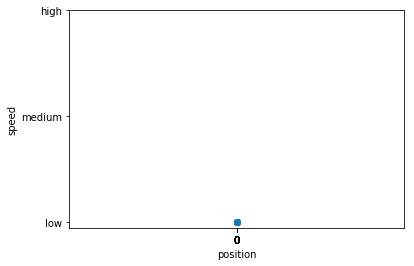

trajectory number :  0


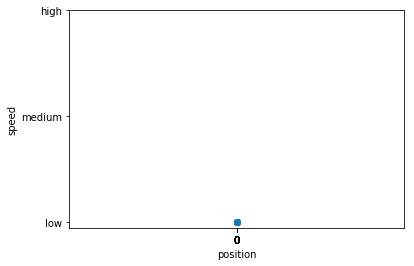

trajectory number :  1


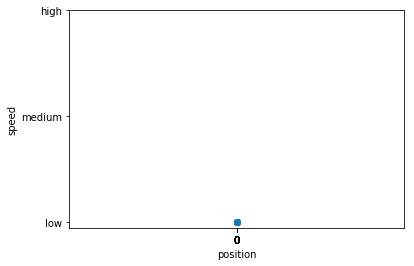

trajectory number :  2


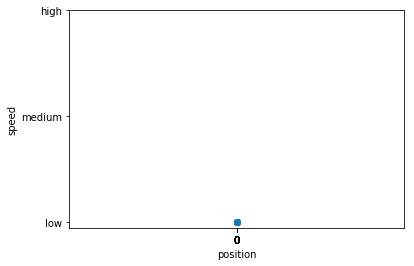

trajectory number :  3


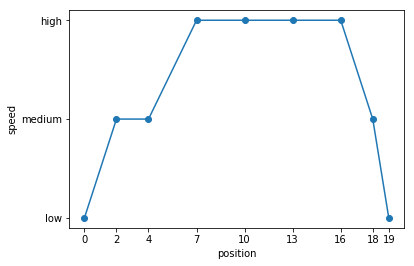

trajectory number :  4


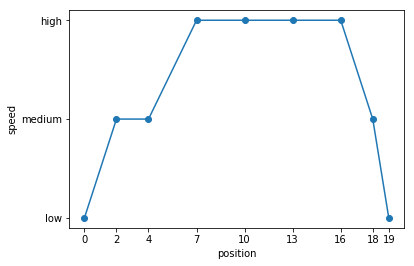

trajectory number :  5


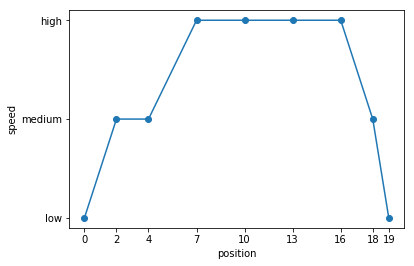

trajectory number :  6


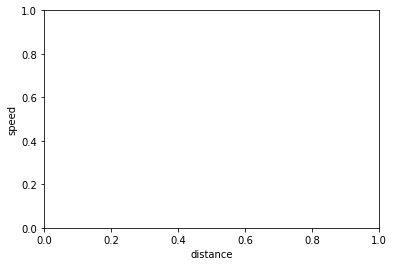

In [23]:
for index,trajectory in enumerate(trajectories) :
    print_trajectory(trajectory,False,False,index)
    plt.xlabel("distance")
    plt.ylabel("speed")
    print("trajectory number : ", index )

Starting from policy maintaining speed at every state

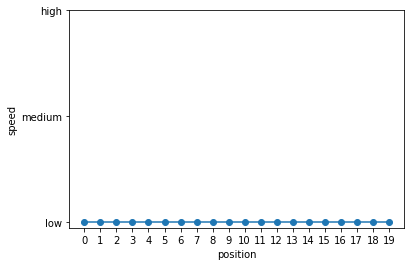

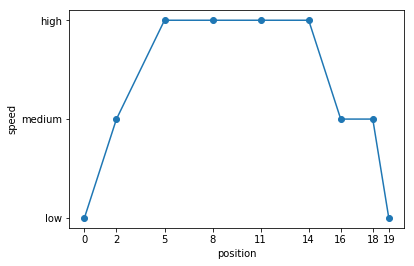

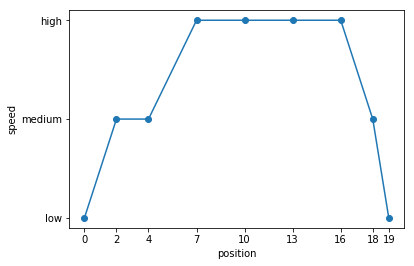

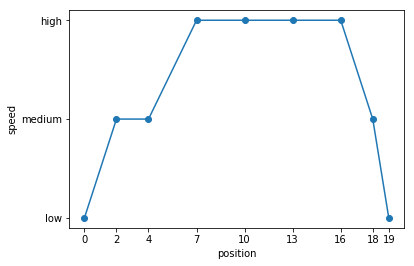

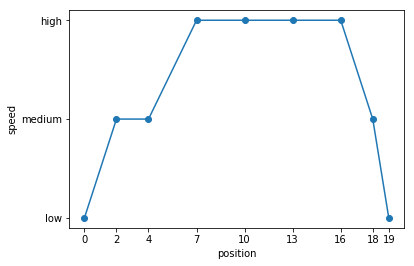

FileNotFoundError: [Errno 2] No such file or directory: 'img/trajectory.jpg'

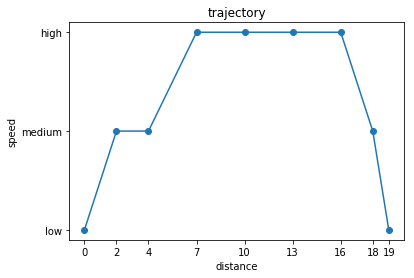

In [24]:
for index,trajectory in enumerate(trajectories_2) :
    print_trajectory(trajectory,False,False,str(index))

print_trajectory(trajectories[len(trajectories)-1],True,False,1)

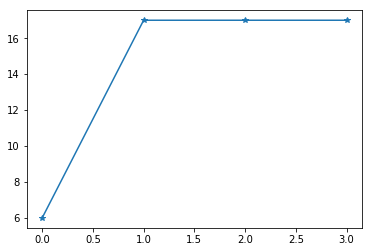

In [106]:
plt.plot(scores_2,marker='*')
plt.show()

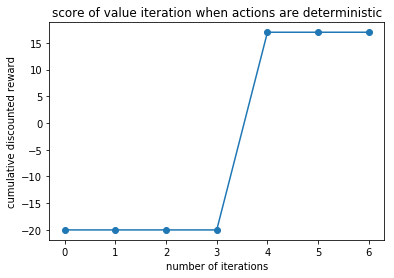

FileNotFoundError: [Errno 2] No such file or directory: 'img/scores.jpg'

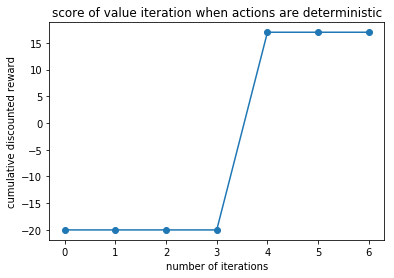

In [25]:
plt.plot(scores,marker='o')
plt.xlabel("number of iterations")
plt.ylabel("cumulative discounted reward")
plt.title("score of value iteration when actions are deterministic")
plt.show()
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(scores,marker='o')
plt.xlabel("number of iterations")
plt.ylabel("cumulative discounted reward")
plt.title("score of value iteration when actions are deterministic")
fig.savefig('img/scores.jpg', dpi = 500)   # save the figure to file
fig.savefig('latex/img/scores.jpg' , dpi = 500)
plt.close(fig)   

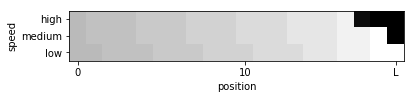

In [35]:
Z = np.array(policy_eval(p,T,R,0.01,gamma)[:trap]).reshape(l,3)

# FLIPPING!
Z = np.flip(Z, 1)
plt.yticks([2,1,0],np.flip(np.array(['high','medium','low']), 0))
plt.xticks([0,10,19],[0,10,'L'])
plt.xlabel('position')
plt.ylabel('speed')
plt.imshow(np.transpose(Z),cmap='gray')
plt.show()

We should try this visualisation for the value of the state but the problem is how to interpret the color ? plus c'est clair plus la valeur de Z est élevée ?? 

To figure out if everything is going well, make sure that at each iteration you keep track of the value vector, as well as the trajectory of the car according to the current policy. The latter allows you to compute the current policy's total reward and plot the evolution.

Then use the stored values to make a video similar to _street_racer.mp4_ on the repo. The following procedure can be used to save figures.

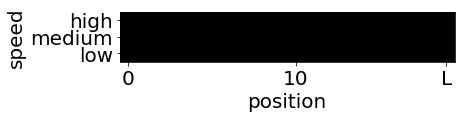

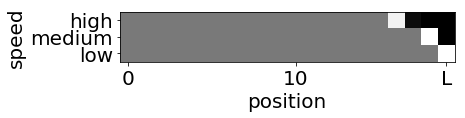

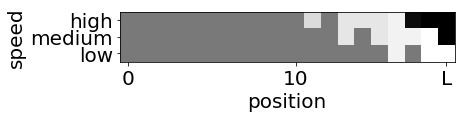

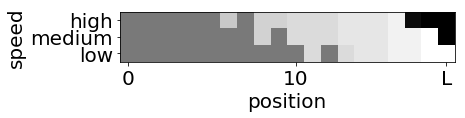

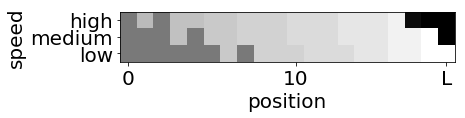

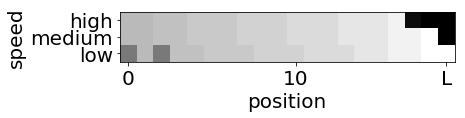

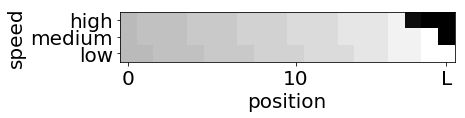

In [39]:
for idx, v in enumerate(values):
    v = np.array(v[:trap]).reshape(l, 3)
    v = np.flip(v, 1)
    plt.yticks([2,1,0],np.flip(np.array(['high','medium','low']), 0))
    plt.xticks([0,10,19],[0,10,'L'])
    plt.xlabel('position', fontsize = 20)
    plt.ylabel('speed', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.imshow(np.transpose(v),cmap='gray')
    plt.show()
    fig = plt.figure(figsize=(l*2, 6), dpi=36)
    ax = fig.add_subplot(111)
    ax.imshow(np.transpose(v), cmap='gray')
    plt.yticks([2,1,0],np.flip(np.array(['high','medium','low']), 0))
    plt.xticks([0,10,19],[0,10,'L'])
    plt.tick_params(axis='both', which='major', labelsize=50)
    plt.tick_params(axis='both', which='minor', labelsize=50)
    plt.xlabel('position', fontsize = 70)
    plt.ylabel('speed', fontsize = 70)
    plt.savefig('img/value'+str(idx)+'.jpg', dpi=36, bbox_inches='tight', pad_inches=0)
    plt.savefig('latex/img/value'+str(idx)+'.jpg', dpi=72, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

Install the command-line utility _ffmpeg_ and use it to transform the saved sequence of images into a mp4 video.

(https://en.wikibooks.org/wiki/FFMPEG_An_Intermediate_Guide/image_sequence#Making_a_video_from_an_Image_Sequence)

Play around with your model. What happens if you introduce uncertainty about the car's brakes?

## Uncertainty on the brakes

the results are a bit strange

In [160]:
# policy iteration
V = np.zeros(n)
p = np.zeros(n)
policy_stable = False
gamma = 0.9
epsilon = 0.01
P=T_2
iterations = 0
scores = []
trajectories_test_rand=[]
values=[]

while not policy_stable and iterations < 100 :
    #print("potatoes")
    values.append(V)
    scores.append(tracker(p,R,P)[2])
    trajectories_test_rand.append(tracker(p,R,P)[1])
    V = policy_eval(p,P,R,epsilon,gamma)
    p, policy_stable = policy_improv(p,V,P,R,A,gamma,epsilon,policy_stable)
    iterations +=1
    #print(iterations)


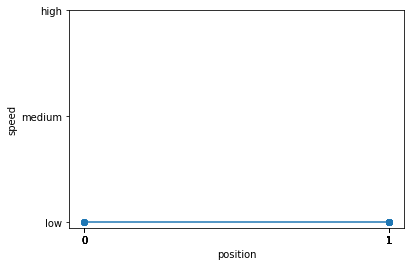

trajectory number :  0


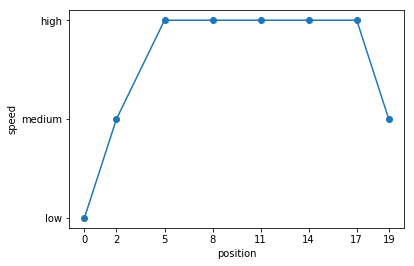

trajectory number :  1


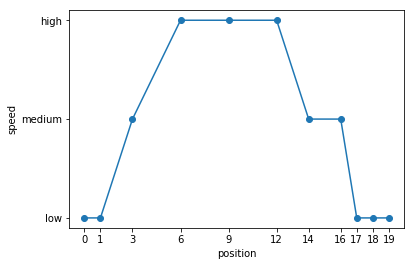

trajectory number :  2


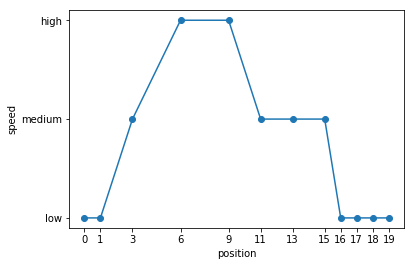

trajectory number :  3


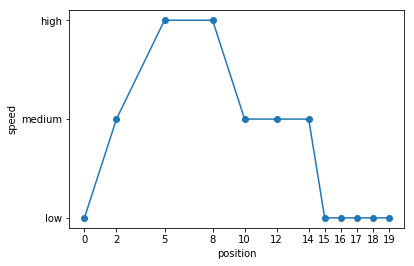

trajectory number :  4


In [163]:
for index,trajectory in enumerate(trajectories_test_rand) :
    print_trajectory(trajectory,True,True,str(index))
    print("trajectory number : ", index )

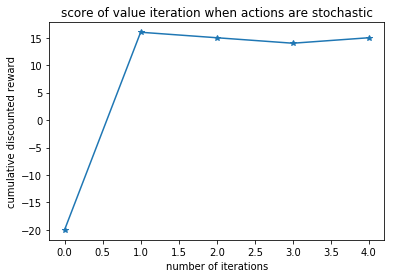

In [162]:

plt.plot(scores,marker='*')
plt.xlabel("number of iterations")
plt.ylabel("cumulative discounted reward")
plt.title("score of value iteration when actions are stochastic")
plt.show()
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
ax.plot(scores,marker='o')
plt.xlabel("number of iterations")
plt.ylabel("cumulative discounted reward")
plt.title("scores of value iteration when actions are stochastic")
fig.savefig('img/scores_rand.jpg')   # save the figure to file
fig.savefig('latex/img/scores_rand.jpg')
plt.close(fig)   

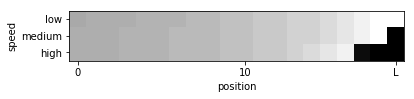

In [113]:
Z = np.array(policy_eval(p,T,R,0.01,gamma)[:trap]).reshape(l,3)
plt.imshow(np.transpose(Z),cmap='gray')
plt.yticks([2,1,0],['high','medium','low'])
plt.xticks([0,10,19],[0,10,'L'])
plt.xlabel('position')
plt.ylabel('speed')
plt.savefig('latex/img/state_values_sto.jpg')
plt.show()



## Tests 

In [133]:
# policy iteration
stop = 100
V = np.zeros(n)
P = np.zeros(n)
sto = 0
gamma = 0.9
scores = []
values = []
trajectories = []
stable = True
while sto < 100:
    sto += 1
    values.append(list(V))
    V = policy_eval( P, T, R,  0.01, gamma)
    P, stable= policy_improv(P, V,T,R,A,gamma,epsilon,stable)
    scores.append(tracker(P,R,T)[2])
    trajectories.append(tracker(P,R,T)[1])
    if stable : 
        break
    
#    s = 0
#    reward = 0
#    trajec = [s]
#    actions = []
#    steps = 0
#    while steps < l+1:
#        steps += 1
#        a = int(P[s])
#        s = nprand.choice(np.where(T[a][s, :] > 0)[0])
#        trajec.append(s)
#        reward += R[s]
#        if s == 3*(l-1) or s == trap:
#            break
#    
#    scores.append(reward)
#    if stable and reward >= max(scores):
#        print('converged')
#        break
#print(sto)
#print(trajec)

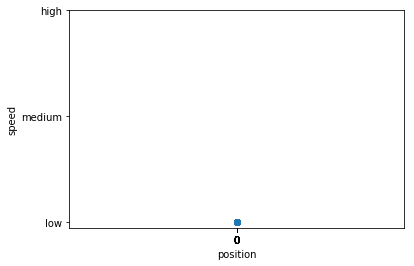

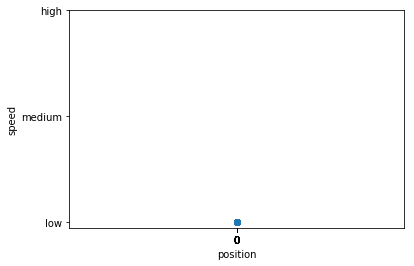

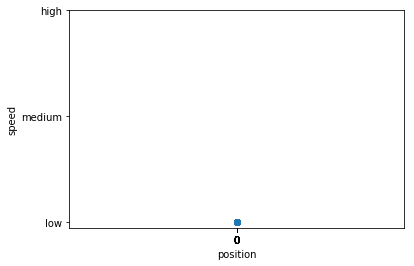

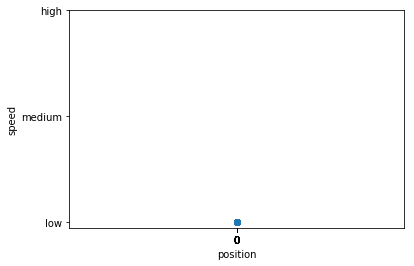

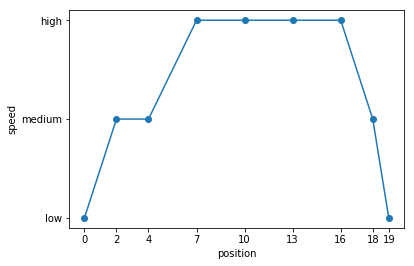

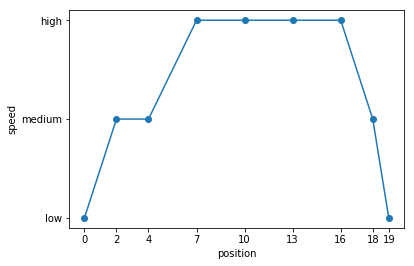

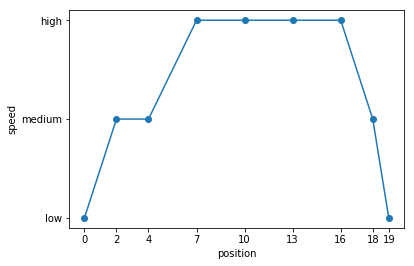

In [134]:
for traj in trajectories:
    print_trajectory(traj,False,False,1)

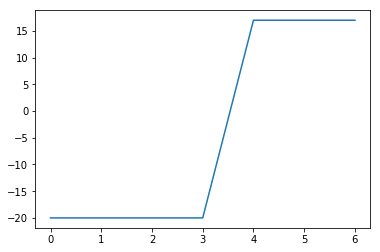

In [135]:
plt.plot(scores)
plt.show()

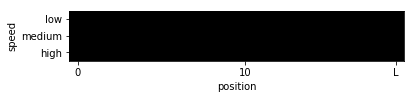

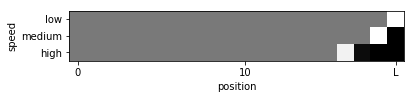

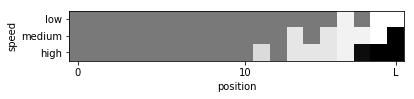

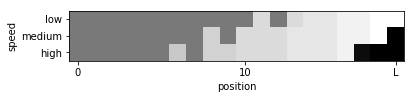

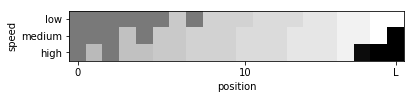

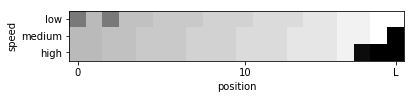

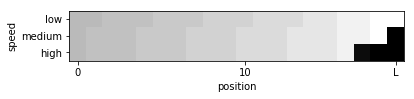

In [137]:
for idx,v in enumerate(values):
    v = np.array(v[:trap]).reshape(l, 3)
    plt.imshow(np.transpose(v),cmap='gray')
    plt.yticks([2,1,0],['high','medium','low'])
    plt.xticks([0,10,19],[0,10,'L'])
    plt.xlabel('position')
    plt.ylabel('speed')
    plt.show()
    fig = plt.figure(figsize=(l*2, 6), dpi=76)
    ax = fig.add_subplot(111)
    ax.imshow(np.transpose(v), cmap='gray')
    plt.close(fig)

### Q-learning algorithm